In [1]:
from utils import *
from brain_seg import brain_seg_factor
from factor import thres_factor_
from brain_segment_vis import *
from swim_ephys import *
from kernel_fit import *
from scipy.stats import spearmanr
%load_ext autoreload
%autoreload 2

df = pd.read_csv('../Processing/data_list.csv')
row = df.iloc[5]
save_root = row['save_dir']+'/'
brain_map = np.load(save_root+'Y_ave.npy').astype('float').squeeze()

_ = np.load(save_root+'brain_seg_factors.npz', allow_pickle=True)
dFF=_['dFF']
lam=_['lam']
loadings=_['loadings']
rotation_mtx=_['rotation_mtx']
phi=_['phi']
scores=_['scores']
scores_rot=_['scores_rot']
x=_['x']
y=_['y']
z=_['z']

num_cells=x.shape[0]
loadings_, valid_c_=thres_factor_(x, y, np.ones(num_cells).astype('bool'), loadings, l_thres_=0.5, shape_thres_=10)
sub_=(np.abs(loadings_)>0).sum(axis=1)>0
valid_c=(np.abs(loadings_)>0).sum(axis=0)>100

x_=x[sub_]
y_=y[sub_]
z_=z[sub_]
loadings__=loadings_[sub_][:,valid_c]

filtered_dFF = scores_rot[valid_c_][valid_c]

print(row['dat_dir'])

/nrs/ahrens/jing/state_modulation/LGGU_vs_NGGU/20191130/fish00/6dpf_HuC-GC7FF_GU-fwd_fish00_exp02_20191130_151303/


In [2]:
save_root

'/nrs/ahrens/Ziqiang/Jing_Glia_project/Processed_data/20191130/fish00/6dpf_HuC-GC7FF_GU-fwd_fish00_exp02_20191130_151303//'

### channel_labels
   Channel label                      (Channel number)
* 'Left ephys',                       # 1
* 'Right ephys',                      # 2
* 'Camera trigger',                   # 3
*  'Observed stimulus velocity',       # 4
*    'Gain',                             # 5
*   'Current epoch',                    # 6
*   'Trial number',                     # 7
*    'Stimulus brightness',              # 8
*   'Command stimulus velocity',        # 9
*   'Stimulus ID'                       # 10

### input structure
* Epoch onset input (`epoch_trial%5 == 0`) from stationary grating to forward grating
* Pulse input in OL or CL: event and amplitude
* swim input in OL or CL
* Passitivity input: exponetially decay

In [2]:
p_dir = row['dat_dir'] + 'processed/'

trial_vars = pd.read_pickle(p_dir+'statemod_expt_trialvars.pkl')
behavior = pd.read_pickle(p_dir+'statemod_expt_behavior.pkl')
statemod = pd.read_pickle(p_dir+'statemod-input-vars.pkl')

ephys_dir = row['dat_dir'] + 'ephys/'
ephys_dat = ephys_dir+'/6dpf_HuC-GC7FF_GU-fwd_fish00_exp05.10chFlt'
fileContent_ = load(ephys_dat)
l_power = windowed_variance(fileContent_[0])[0]
r_power = windowed_variance(fileContent_[1])[0]
camtrig = fileContent_[2]

indx = ep2frame(camtrig, thres=3.8)
frame_ = np.zeros(len(camtrig))
frame_[indx]=1
frame_ = frame_.cumsum()

slide_win = 180000
r_power_baseline = rolling_perc(r_power, window=slide_win, perc=0.1)
l_power_baseline = rolling_perc(l_power, window=slide_win, perc=0.1)

l_power_ = np.clip(l_power-l_power_baseline, 0, None)*10000
r_power_ = np.clip(r_power-r_power_baseline, 0, None)*10000

frame_len = np.min(np.unique(indx[1:]-indx[:-1]))

epoch_frame = np.median(wrap_data(fileContent_[5], indx, frame_len), axis=0).astype('int')
swim_frame = np.mean(wrap_data(l_power_, indx, frame_len), axis=0)
pulse_frame = np.median(wrap_data(fileContent_[8], indx, frame_len), axis=0).astype('int')
visu_frame = np.mean(wrap_data(fileContent_[3], indx, frame_len), axis=0)
visu_frame_ = visu_frame.copy()
visu_frame_[visu_frame_<0]=0

In [3]:
def comp_dFF(ncomp):
    f_load = loadings__[:,ncomp]
    idx = f_load>np.abs(f_load).max()*.3
    idx_ = -f_load>np.abs(f_load).max()*.3
    if idx.sum()<idx_.sum():
        idx = idx_
    f_load_ = f_load.copy()
    f_load_[~idx]=0
    f_load_ = f_load_/f_load_.sum()
    return dFF[sub_].T.dot(f_load_)

In [4]:
## check this
def resp_fg(dFF_cell):
    dFF_trial = []
    swim_trial = []
    epoch_trial = []
    type_trial = []
    pulse_trial = []
    epoch_on_trial = []
    pass_on_trial = []
    epoch_fg_trial = []
    trial_type = []
    visu_trial = []

    for n_ in range(len(trial_vars)):
        trial_inds = trial_vars.iloc[n_]['trial_inds']
        trial_frame = np.unique(frame_[trial_inds]).astype('int')
        trial_frame = np.r_[np.arange(trial_frame[0]-10, trial_frame[0]).astype('int'), trial_frame[:-5]]
        epoch_trial.append(epoch_frame[trial_frame])
        epoch_on = epoch_frame[trial_frame]%5==0
        epoch_on_t = np.where((epoch_on[1:]) & (~epoch_on[:-1]))[0]
        epoch_on[:]=False
        epoch_on[epoch_on_t]=True
        epoch_on_trial.append(epoch_on)
        epoch_fg_trial.append(epoch_frame[trial_frame]%5<2)
        swim_trial.append(swim_frame[trial_frame])
        pulse_epoch = (epoch_frame[trial_frame]%5==3)
        pulse_trial.append(pulse_frame[trial_frame]*pulse_epoch)
        dFF_trial.append(dFF_cell[trial_frame]-dFF_cell[trial_frame][:10].mean())
        type_trial.append(epoch_frame[trial_frame]>4)
        visu_trial.append(visu_frame_[trial_frame])
    type_trial_=[]
    for n in type_trial:
        type_trial_.append(n[20])
    type_trial_ = np.array(type_trial_)
    
    dFF_ = []
    fg_ = []
    visu_ = []
    
    for n, n_trial in enumerate(dFF_trial):
        # dFF_.append(n_trial[:100]*epoch_fg_trial[n][:100])
        dFF_.append(n_trial[epoch_fg_trial[n]])
        fg_.append(np.arange(epoch_fg_trial[n].sum()))
        visu_.append(visu_trial[n][epoch_fg_trial[n]])
    dFF_ = np.array(dFF_)
    fg_ = np.array(fg_)
    visu_ = np.array(visu_)
    
    _ = minimize(mse_exp_const, [5, 0.4, 0], args=(dFF_, fg_), bounds=[(0, np.inf), (0, np.inf), (0, np.inf)])
    a, b, c = _['x']
    w_resp_fg = exp_const(np.arange(100), a, b, c)
    dFF_all = np.hstack(dFF_)
    var_ = ((dFF_all-dFF_all.mean())**2).sum()
    mse_ = _['fun']
    ev_fg = 1-mse_/var_
    print(f'EV: {ev_fg}')
    
    dFF_ = []
    for n, n_trial in enumerate(dFF_trial):
        if (b>0) and (ev_fg>0):
            m_ = n_trial[epoch_fg_trial[n]]
            m_ -= exp_const(np.arange(epoch_fg_trial[n].sum()), a, b, c)
            n_trial[epoch_fg_trial[n]] = m_
        dFF_.append(n_trial)
    dFF_ = np.array(dFF_)
    visu_ = np.array(visu_trial)
    
    w_visu = np.exp(-np.arange(20)/6)
    _ = minimize(mse_bw_visu, w_visu, args=(dFF_, visu_))
    w_visu = _['x']
    dFF_all = np.hstack(dFF_)
    var_ = ((dFF_all-dFF_all.mean())**2).sum()
    mse_ = _['fun']
    ev_visu = 1-mse_/var_
    print(f'EV: {ev_visu}')

    return w_resp_fg, w_visu, ev_fg, ev_visu

In [5]:
def resp_pulse(dFF_cell):
    dFF_trial = []
    swim_trial = []
    epoch_trial = []
    type_trial = []
    pulse_trial = []
    epoch_on_trial = []
    pass_on_trial = []
    epoch_fg_trial = []
    trial_type = []

    for n_ in range(len(trial_vars)):
        trial_inds = trial_vars.iloc[n_]['trial_inds']
        trial_frame = np.unique(frame_[trial_inds]).astype('int')
        trial_frame = np.r_[np.arange(trial_frame[0]-10, trial_frame[0]).astype('int'), trial_frame]
        epoch_trial.append(epoch_frame[trial_frame])
        epoch_on = epoch_frame[trial_frame]%5==0
        epoch_on_t = np.where((epoch_on[1:]) & (~epoch_on[:-1]))[0]
        epoch_on[:]=False
        epoch_on[epoch_on_t]=True
        epoch_on_trial.append(epoch_on)
        epoch_fg_trial.append(epoch_frame[trial_frame]%5<2)
        swim_trial.append(swim_frame[trial_frame])
        pulse_epoch = (epoch_frame[trial_frame]%5==3)
        pulse_trial.append(pulse_frame[trial_frame]*pulse_epoch)
        dFF_trial.append(dFF_cell[trial_frame]-dFF_cell[trial_frame][:10].mean())
        type_trial.append(epoch_frame[trial_frame]>4)
    
    dFF_ = []
    catch_trial = []
    type_ = []
    for n, n_trial in enumerate(dFF_trial):
        if pulse_trial[n].sum()>0:
            pulse_ = np.where(pulse_trial[n][1:] & ~pulse_trial[n][:-1])[0]
            n_trial -= n_trial[pulse_[0]-1:pulse_[0]].mean()
            dFF_.append(n_trial[pulse_[-1]+1:pulse_[-1]+11])
            type_.append(type_trial[n][20])
            catch_trial.append(False)
        else:
            catch_trial.append(True)
    dFF_ = np.array(dFF_)
    w_pulse = dFF_.mean(axis=0) - min(dFF_.mean(axis=0).min(),0)
    w_pulse[0]=0
    w_pulse = w_pulse/w_pulse.max()
    w_pulse = np.r_[w_pulse, np.zeros(5)]
    
    dFF_ = []
    catch_trial = []
    type_ = []
    pulse_ = []
    swim_ = []
    len_ = 195
    for n, n_trial in enumerate(dFF_trial):
        if pulse_trial[n].sum()>0:
            pulse_on = np.where(pulse_trial[n][1:] & ~pulse_trial[n][:-1])[0][0]
            pulse_input = np.zeros(pulse_trial[n].shape)
            pulse_input[np.where(pulse_trial[n][1:] & ~pulse_trial[n][:-1])[0]+1]=1
            n_trial -= n_trial[pulse_on-5:pulse_on].mean()
            dFF_.append(n_trial[pulse_on-5:pulse_on+len_])
            pulse_.append(pulse_input[pulse_on-5:pulse_on+len_])
            swim_.append(swim_trial[n][pulse_on-5:pulse_on+len_])
            type_.append(type_trial[n][20])
            catch_trial.append(False)
        else:
            catch_trial.append(True)
    dFF_ = np.array(dFF_)
    pulse_ = np.array(pulse_)
    swim_ = np.array(swim_)
    swim_ = swim_ - np.median(swim_, axis=-1, keepdims=True)
    
    dFF_min = dFF_.copy()
    for n in range(dFF_.shape[0]):
        dFF_min[n] = eroll_min(dFF_[n])
    dFF_rm_min = dFF_ - dFF_min
    
    cl_type=np.array(type_)==0
    g_t_cl = np.ones(30)*0.1
    w_cl_pulse = w_pulse.copy()
    
    win_t = 9
    lambda_=np.r_[100, np.ones(win_t)*.01, np.ones(len(w_cl_pulse)-win_t-1)*100]
    
    dFF_fit = dFF_.copy()

    for n in range(5):
        _ = minimize(mse_pulse_g_t_resp, g_t_cl, args=(dFF_fit[cl_type], pulse_[cl_type], w_cl_pulse))
        g_t_cl = _['x']
        # g_t_cl = np.ones(g_t_cl.shape)*g_t_cl.mean()
        _ = minimize(mse_pulse_w_pulse_resp_, w_cl_pulse, args=(dFF_fit[cl_type], pulse_[cl_type], g_t_cl, lambda_), options={'gtol': 1e-06})
        w_cl_pulse = _['x']
        w_cl_pulse -=min(w_cl_pulse.min(), 0)
        w_cl_pulse = w_cl_pulse/w_cl_pulse.max()
    
    ol_type=np.array(type_)==1
    g_t_ol = np.ones(30)*0.1
    w_ol_pulse = w_pulse.copy()

    for n in range(5):
        _ = minimize(mse_pulse_g_t_resp, g_t_ol, args=(dFF_fit[ol_type], pulse_[ol_type], w_ol_pulse))
        g_t_ol = _['x']
        # g_t_ol = np.ones(g_t_ol.shape)*g_t_ol.mean()
        _ = minimize(mse_pulse_w_pulse_resp_, w_ol_pulse, args=(dFF_fit[ol_type], pulse_[ol_type], g_t_ol, lambda_))
        w_ol_pulse = _['x']
        w_ol_pulse -=min(w_ol_pulse.min(), 0)
        w_ol_pulse = w_ol_pulse/w_ol_pulse.max()

    g_t_matrix = np.zeros((dFF_.shape[0], len(g_t_cl)))
    g_t_matrix_smooth = g_t_matrix.copy()
    dFF_est = dFF_.copy()
    
    mse_= 0
    for n in range(dFF_.shape[0]):
        if type_[n]==0:
            g_t = g_t_cl
            w_pulse_ = w_cl_pulse
        else:
            g_t = g_t_ol
            w_pulse_ = w_ol_pulse        
        mse_ += mse_pulse_w_pulse_resp(w_pulse_, dFF_fit[n][None,:], pulse_[n][None,:], g_t)
        _ = minimize(mse_pulse_g_t_resp, g_t, args=(dFF_fit[n][None,:], pulse_[n][None,:], w_pulse_))
        g_t_matrix[n] = _['x']
        g_t_matrix_smooth[n] = gp_smooth(_['x'])
        dFF_est[n] = pulse_resp(pulse_[n], _['x'], w_pulse_)
        # mse_ += _['fun']
    g_t_matrix_ = g_t_matrix_smooth/g_t_matrix_smooth[:,0:3].max(axis=-1, keepdims=True)
    
    # explained variance
    var_ = ((dFF_fit.flatten()-dFF_fit.flatten().mean())**2).sum()
    ev_pulse = 1-mse_/var_
    print(f'EV: {ev_pulse}')
    
    return w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse

In [6]:
def resp_motor(dFF_cell, w_cl_pulse=None, w_ol_pulse=None, w_resp_fg=None):
    dFF_trial = []
    swim_trial = []
    epoch_trial = []
    type_trial = []
    pulse_trial = []
    epoch_on_trial = []
    pass_on_trial = []
    epoch_fg_trial = []
    trial_type = []

    for n_ in range(len(trial_vars)):
        trial_inds = trial_vars.iloc[n_]['trial_inds']
        trial_frame = np.unique(frame_[trial_inds]).astype('int')
        trial_frame = np.r_[np.arange(trial_frame[0]-10, trial_frame[0]).astype('int'), trial_frame[:-5]]
        epoch_trial.append(epoch_frame[trial_frame])
        epoch_on = epoch_frame[trial_frame]%5==0
        epoch_on_t = np.where((epoch_on[1:]) & (~epoch_on[:-1]))[0]
        epoch_on[:]=False
        epoch_on[epoch_on_t]=True
        epoch_on_trial.append(epoch_on)
        epoch_fg_trial.append(epoch_frame[trial_frame]%5<2)
        swim_trial.append(swim_frame[trial_frame])
        pulse_epoch = (epoch_frame[trial_frame]%5==3)
        pulse_trial.append(pulse_frame[trial_frame]*pulse_epoch)
        dFF_trial.append(dFF_cell[trial_frame]-dFF_cell[trial_frame][:10].mean())
        type_trial.append(epoch_frame[trial_frame]>4)

    swim_trial_ = swim_trial.copy()
    for n, nswim_ in enumerate(swim_trial_):
        nswim = nswim_ - np.percentile(nswim_, 10)
        nswim[nswim<0]=0
        swim_trial_[n]=nswim
    t_pre=10
    t_post=100
    g_motor = np.exp(-np.arange(t_post)/10)
    g_motor = np.r_[np.zeros(t_pre), g_motor]

    dFF_trial = np.array(dFF_trial)
    swim_trial_ = np.array(swim_trial_)
    type_trial = np.array(type_trial)
    type_trial_ = []
    for n in type_trial:
        type_trial_.append(n[20])
    type_trial_ = np.array(type_trial_)
    
    
    if w_resp_fg is not None:
        for n, ntrial in enumerate(dFF_trial):
            ntrial[epoch_fg_trial[n]] -= w_resp_fg[:epoch_fg_trial[n].sum()]
            dFF_trial[n] = ntrial
    if (w_cl_pulse is not None) and (w_ol_pulse is not None):
        g_t = np.ones(30)*0.1
        for n, ntrial in enumerate(dFF_trial):
            pulse_input = np.zeros(pulse_trial[n].shape)
            pulse_input[np.where(pulse_trial[n][1:] & ~pulse_trial[n][:-1])[0]+1]=1
            if type_trial_[n]==0:
                w_pulse_ = w_cl_pulse
            else:
                w_pulse_ = w_ol_pulse        
            _ = minimize(mse_pulse_g_t_resp_s, g_t, args=(ntrial, pulse_input, w_pulse_))
            dFF_trial[n] = ntrial-pulse_resp(pulse_trial[n], g_t, w_pulse_)

    dFF_min = dFF_trial.copy()
    dFF_rm_min = dFF_trial.copy()
    for n in range(dFF_trial.shape[0]):
        dFF_min[n] = eroll_min(dFF_trial[n])
        dFF_rm_min[n] = dFF_trial[n] - dFF_min[n]

    _ = minimize(mse_motor_w_motor_resp, g_motor, args=(dFF_trial, swim_trial_, t_pre))
    g_motor = _['x']
    mse_ = 0
    _ = minimize(mse_motor_w_motor_resp, g_motor, args=(dFF_trial[type_trial_==0], swim_trial_[type_trial_==0], t_pre))
    g_motor_cl = _['x']
    mse_ +=_['fun']
    _ = minimize(mse_motor_w_motor_resp, g_motor, args=(dFF_trial[type_trial_==1], swim_trial_[type_trial_==1], t_pre))
    g_motor_ol = _['x']
    mse_ +=_['fun']
    
    var_ = ((np.hstack(dFF_trial)-np.hstack(dFF_trial).mean())**2).sum()
    ev_motor = 1-mse_/var_
    print(f'EV: {ev_motor}')
    
    return g_motor_cl, g_motor_ol, ev_motor

In [7]:
# fit_results = []

# for cell_id in range(filtered_dFF.shape[0]):
#     print(cell_id)
#     dFF_cell = comp_dFF(cell_id)
#     try:
#         w_resp_fg, w_visu, ev_fg, ev_visu = resp_fg(dFF_cell)
#     except:
#         w_resp_fg, w_visu, ev_fg, ev_visu = (None, None, -1, -1)
#     if ev_fg<0.1:
#         w_resp_fg_ = None
#     else:
#         w_resp_fg_ = w_resp_fg.copy()
#     try:
#         w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse = resp_pulse(dFF_cell)
#     except:
#         w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse =(None, None, None, -1)
#     if ev_pulse<0.1:
#         w_cl_pulse_ = None
#         w_ol_pulse_ = None
#     else:
#         w_cl_pulse_ = w_cl_pulse.copy()
#         w_ol_pulse_ = w_ol_pulse.copy()
#     try:
#         g_motor_cl, g_motor_ol, ev_motor = resp_motor(dFF_cell, w_cl_pulse=w_cl_pulse_, w_ol_pulse=w_ol_pulse_, w_resp_fg=w_resp_fg_)
#     except:
#         g_motor_cl, g_motor_ol, ev_motor = (None, None, -1)
#     fit_results.append([w_resp_fg, w_visu, ev_fg, ev_visu, w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse, g_motor_cl, g_motor_ol, ev_motor])

In [9]:
# fit_results_ = np.array(fit_results)
# np.save('fit_results', fit_results_)
fit_results_ = np.load('fit_results.npy', allow_pickle=True)

0


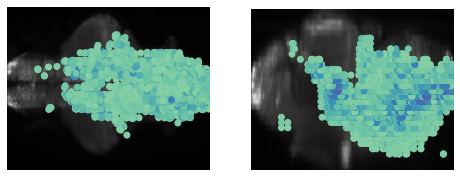

0.9033325079187391


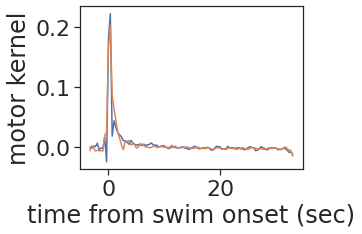

1


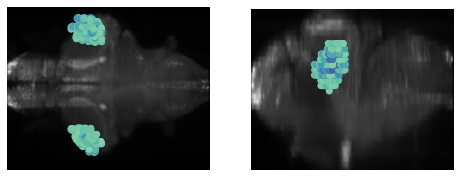

0.10180314612632424


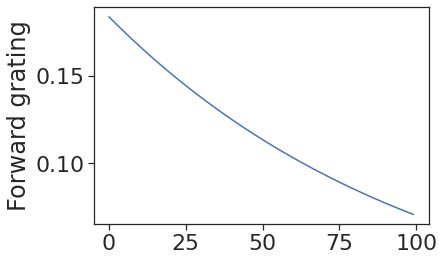

0.6675066576045687


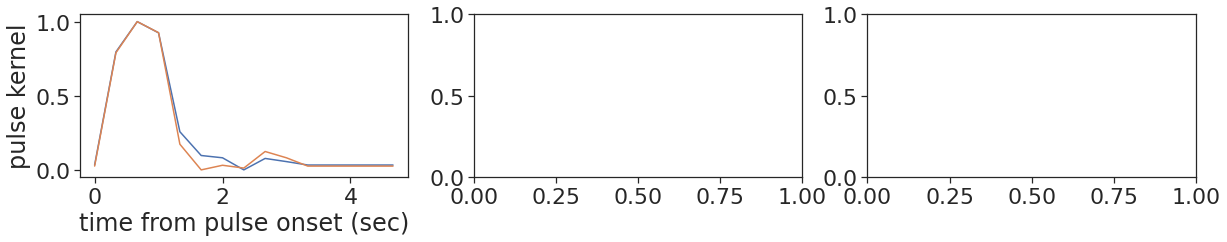

2
3
4


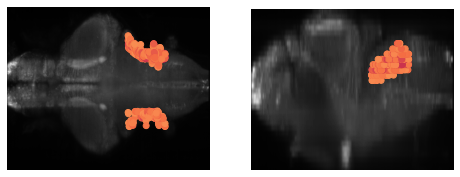

0.24066191857857133


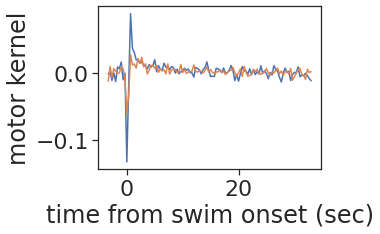

5
6
7
8


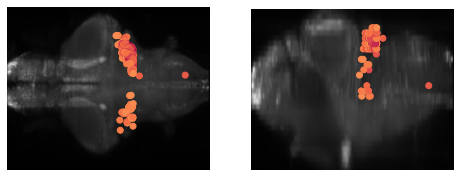

0.12486759027252481


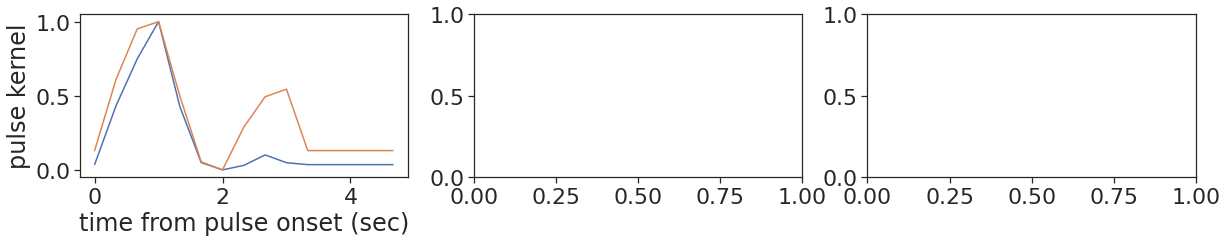

0.8078406157326998


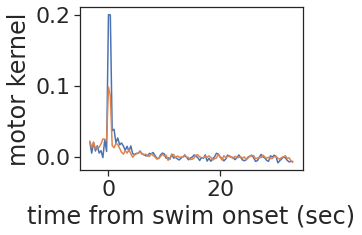

9
10


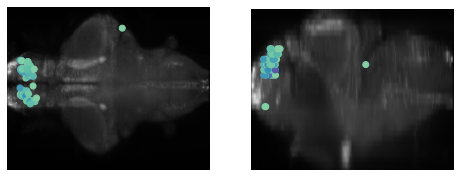

0.5336274130437536


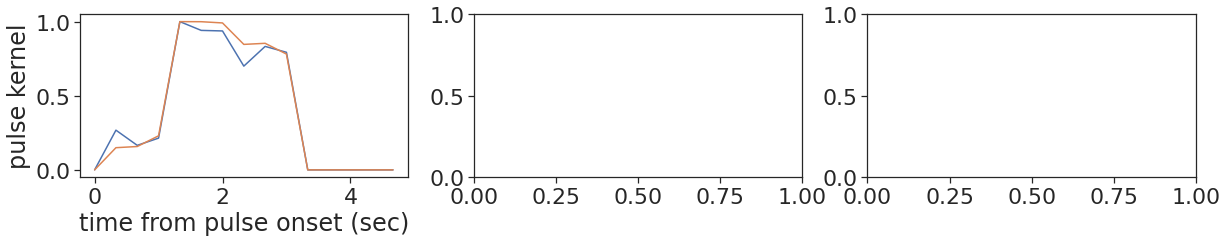

0.6895363956809475


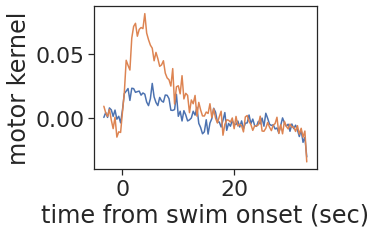

11
12


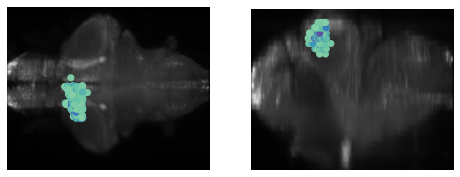

0.2019167334503189


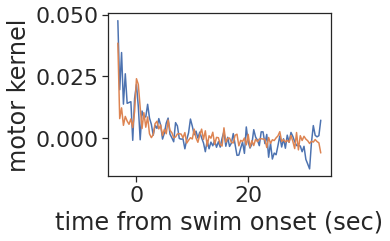

13


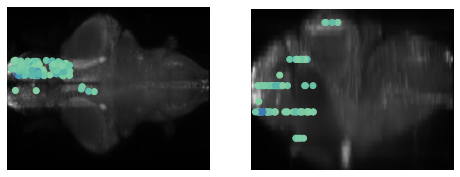

0.29483815846195005


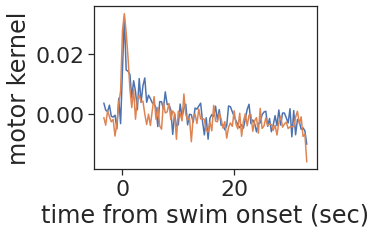

14


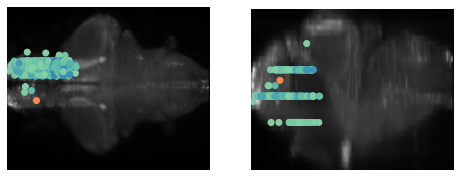

0.35708790425174486


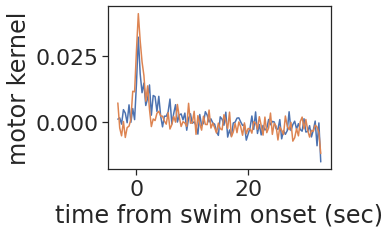

15


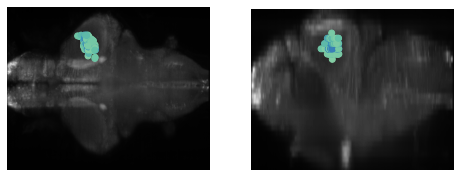

0.11233697559175282


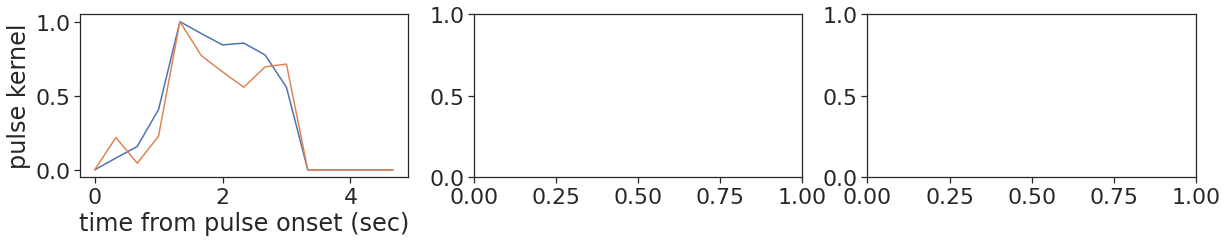

0.14485469339870294


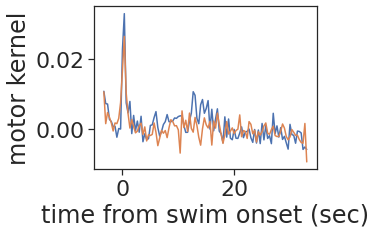

16


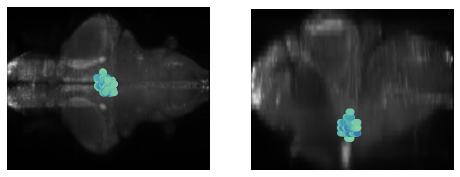

0.4508880524267357


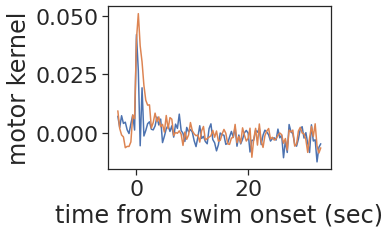

17


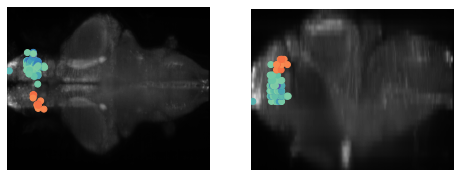

0.1265203063412219


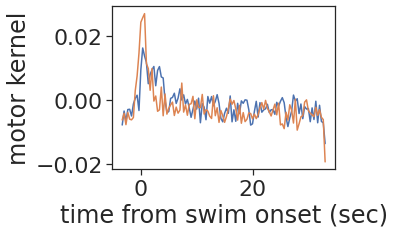

18


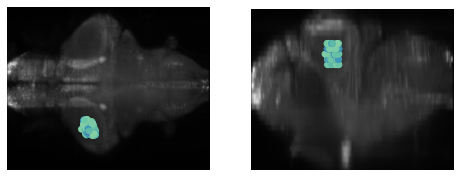

0.15810649983445535


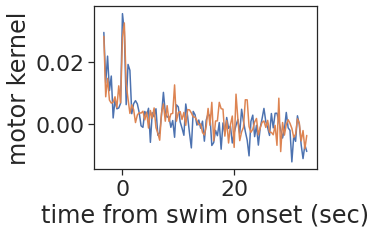

19
20
21


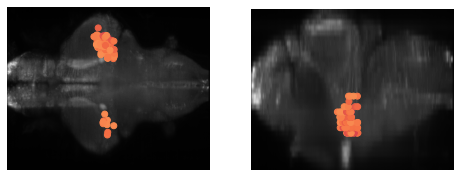

0.33770142352523214


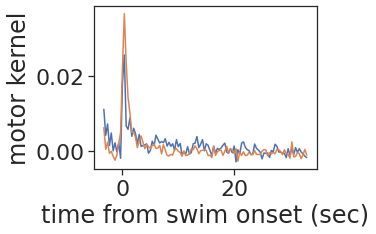

22


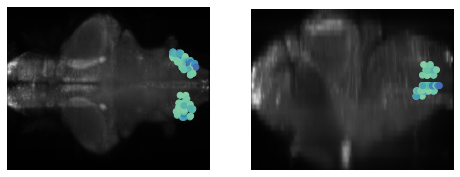

0.2356018592689716


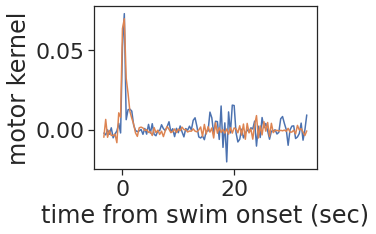

23
24


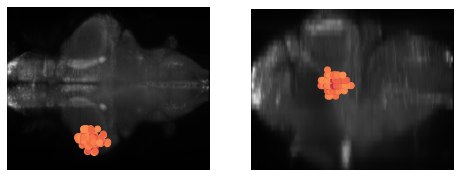

0.4842555410012025


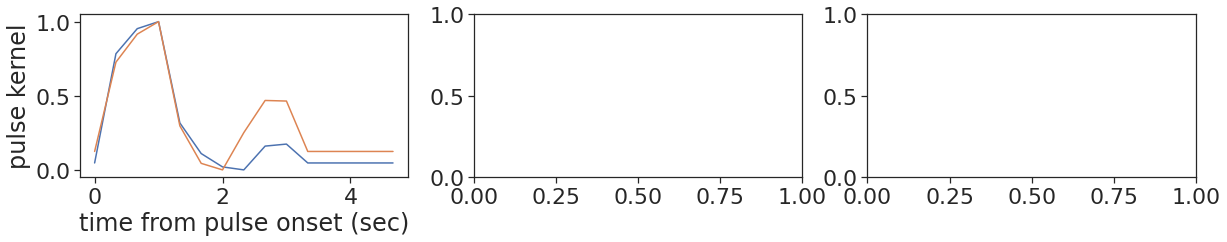

0.2996012501531935


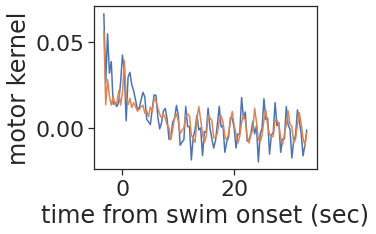

25


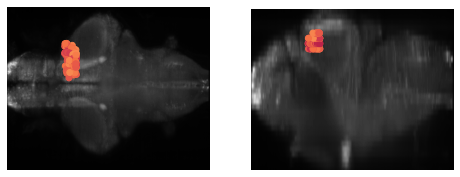

0.15268905753984463


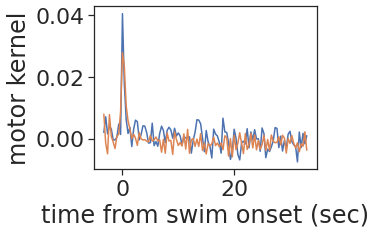

26


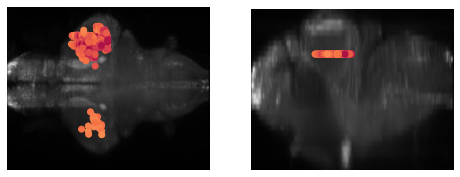

0.3009086324445239


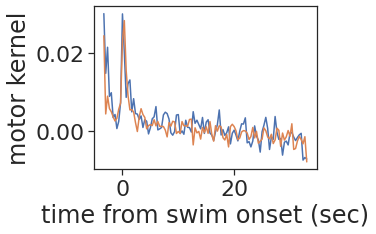

27


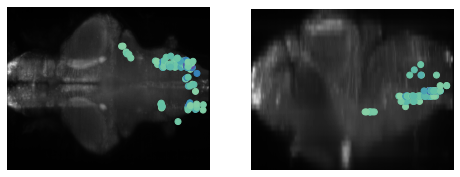

0.5596925545338965


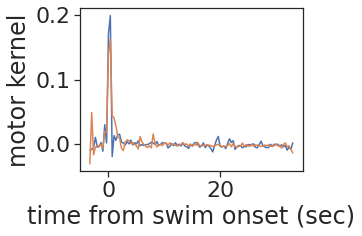

28
29


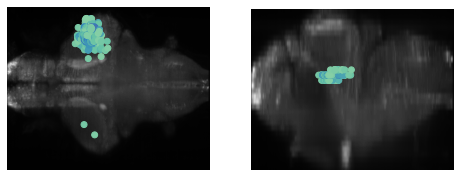

0.263923762925672


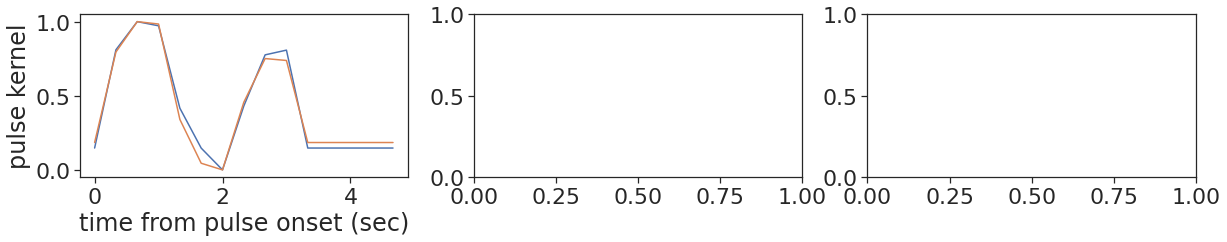

0.32227597617583814


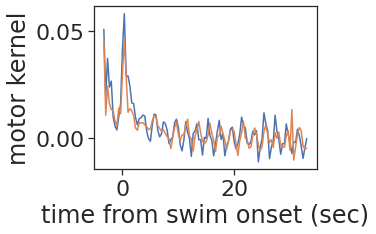

30


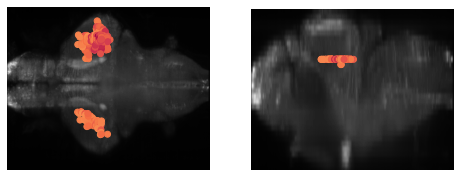

0.3025360556978117


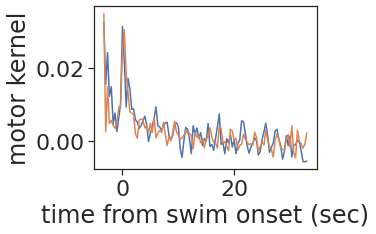

31


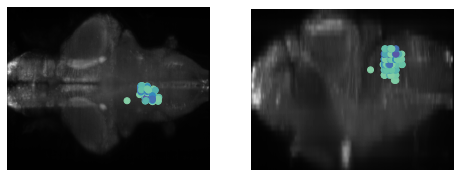

0.1187073844352734


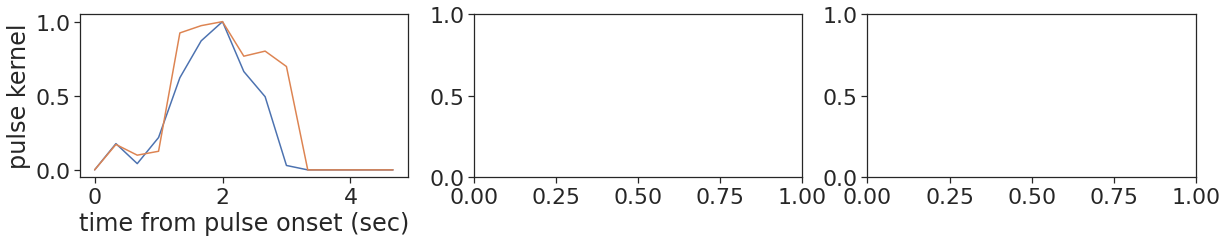

0.7708840715414811


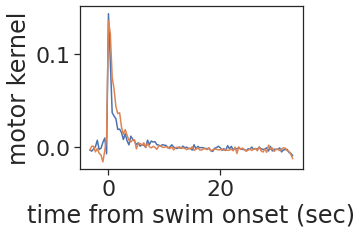

32


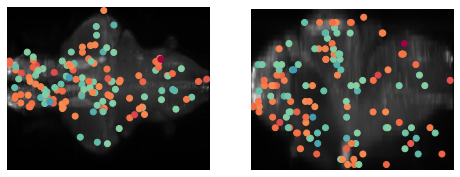

0.5237288461583711


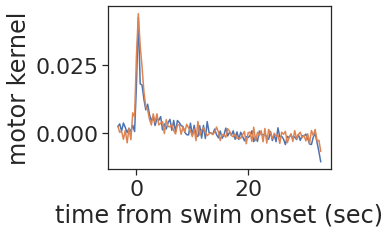

33


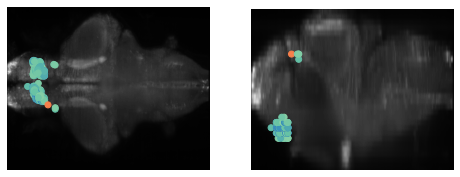

0.13472916624583242


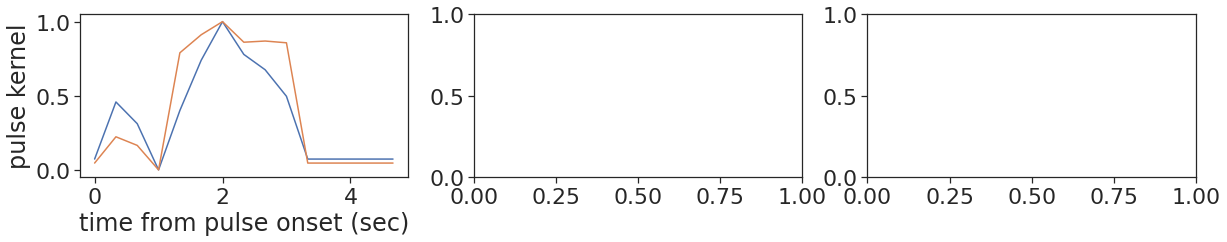

0.6875474673005582


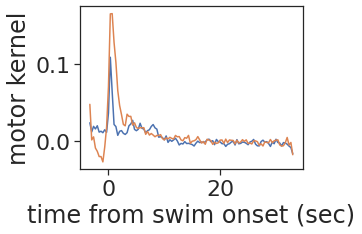

34


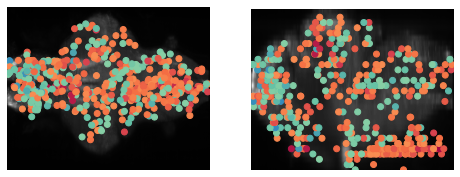

0.10262520403299713


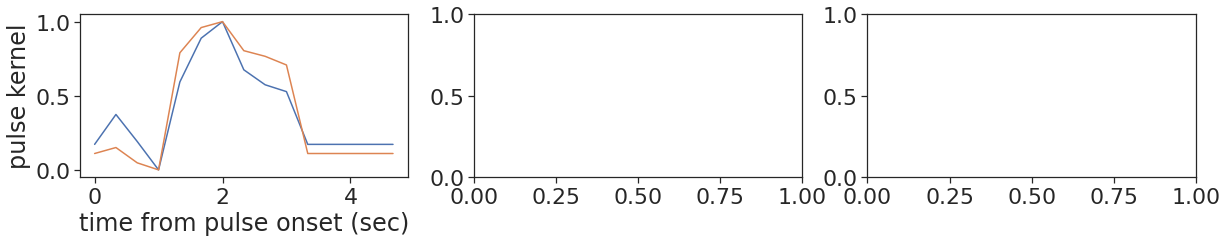

0.7926813742910891


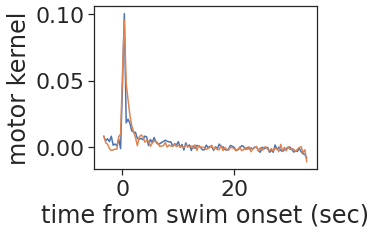

35


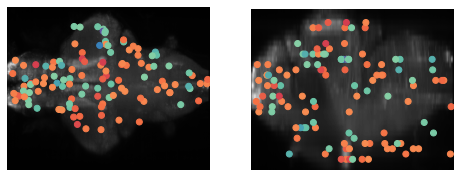

0.6741817524445217


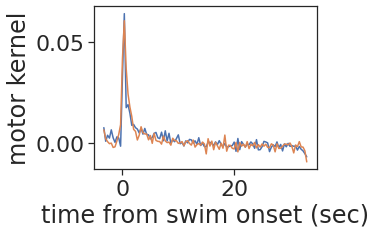

36


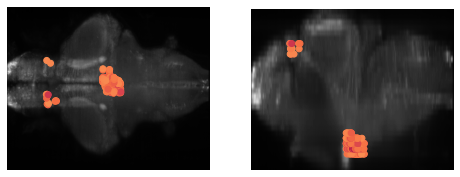

0.4333298656822506


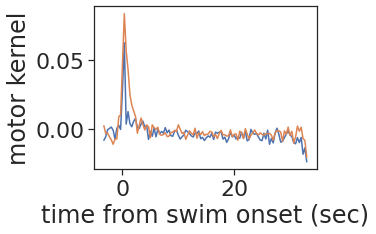

37


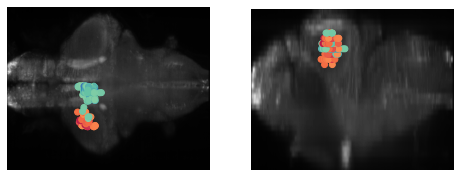

0.1352829844018656


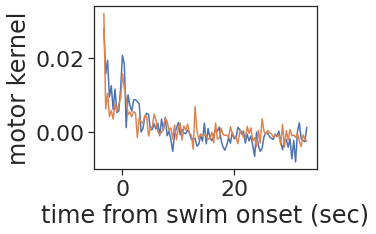

38


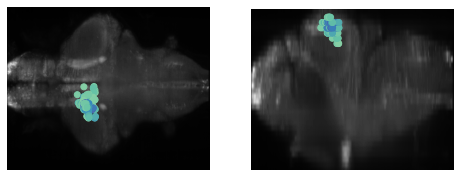

0.19503435690145354


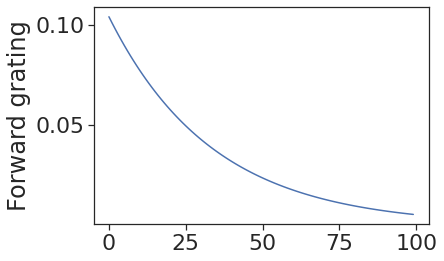

39


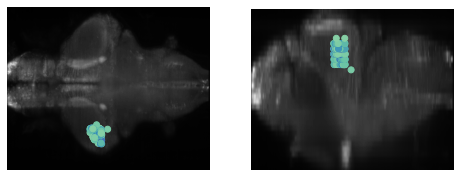

0.2036417378355665


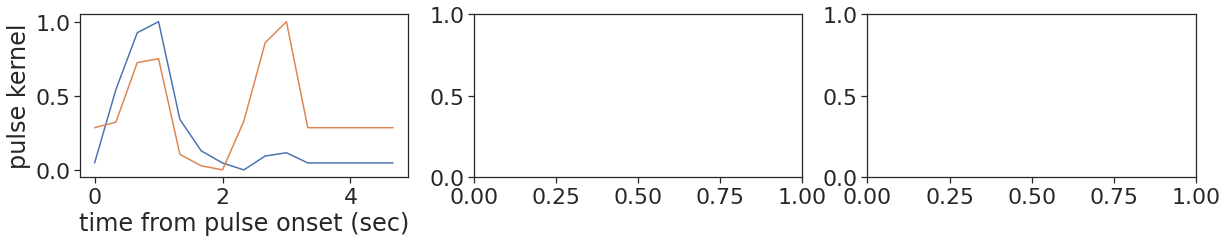

0.2615514678924328


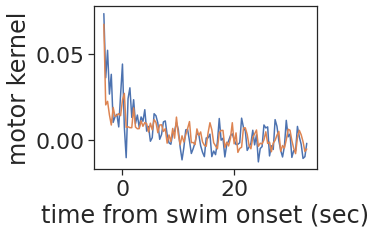

40


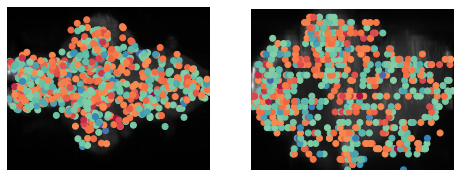

0.14203844254742382


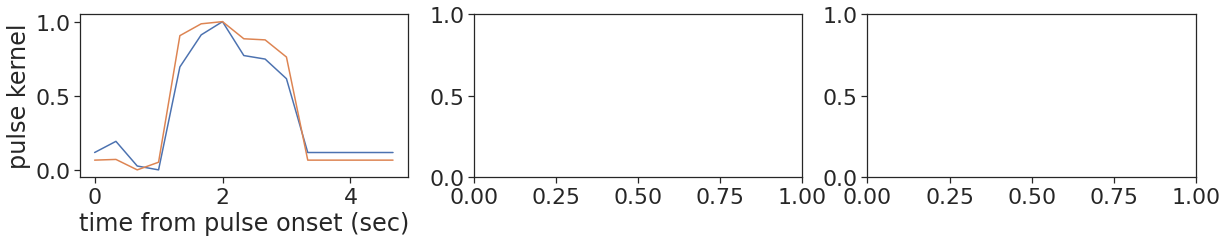

0.7202728025754335


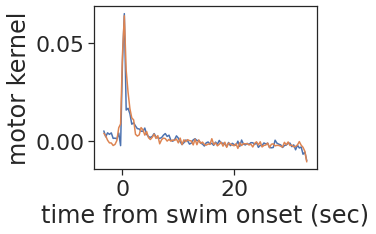

41


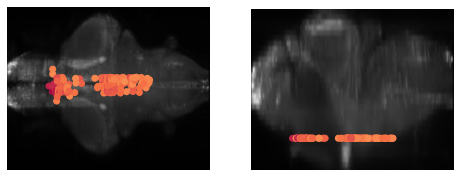

0.5121364694269541


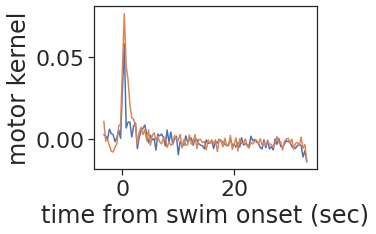

42


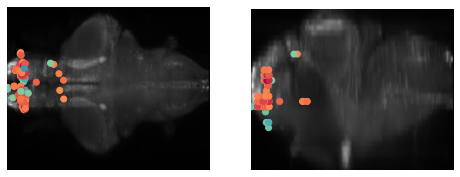

0.13650003833693225


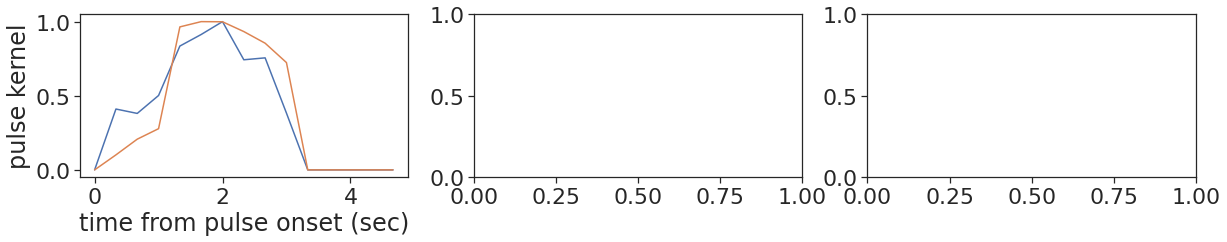

0.1998396437618003


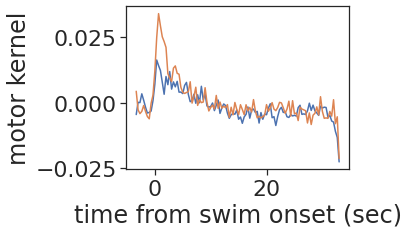

43


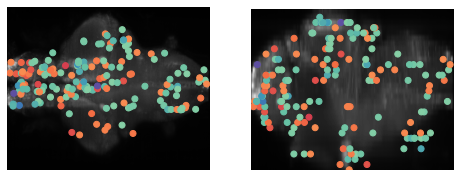

0.6084354165736209


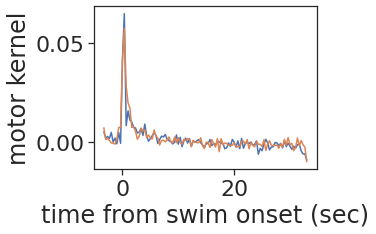

44


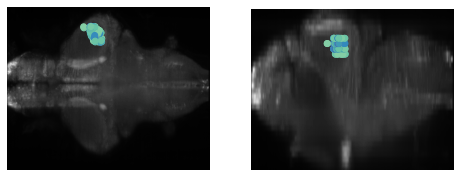

0.12531455136815617


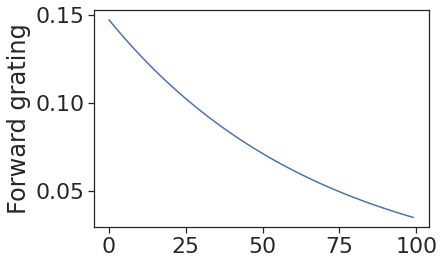

0.36479279678558707


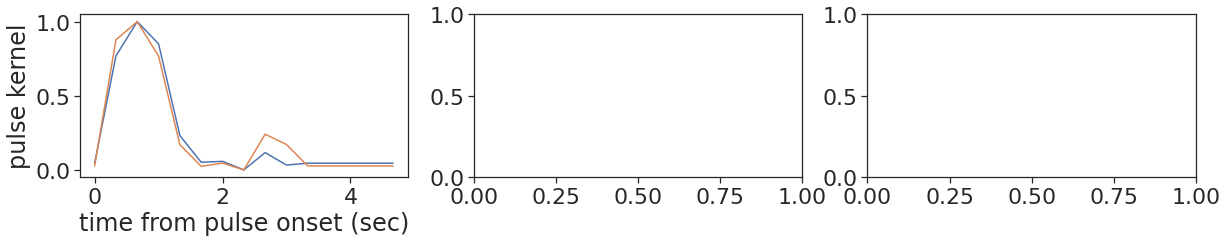

45


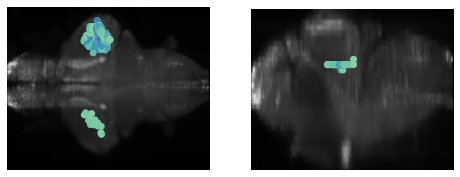

0.24146793238366926


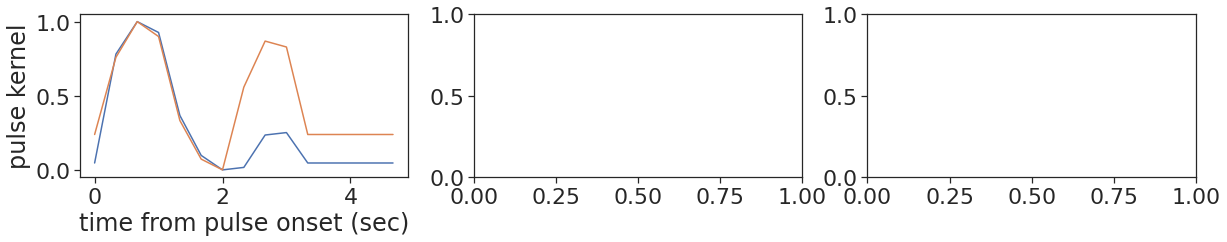

0.29944602116833374


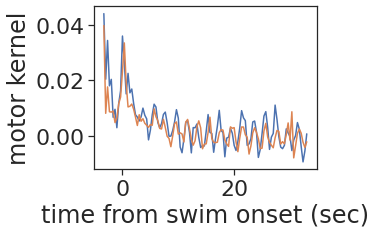

46


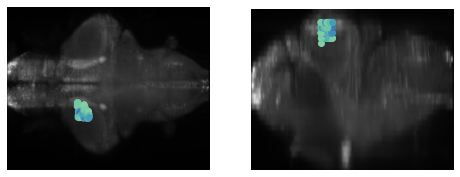

0.14650598332353337


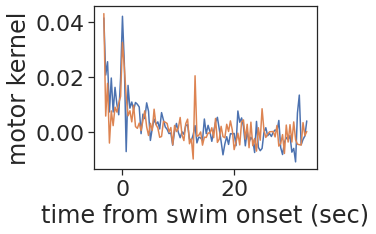

47


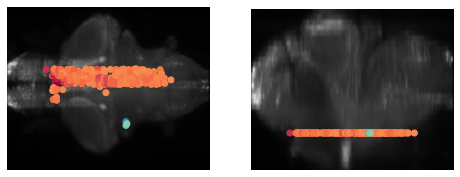

0.6968084807177227


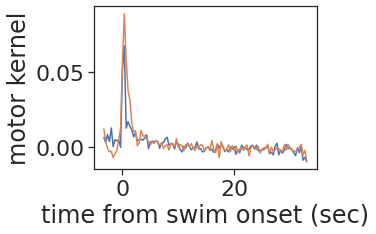

48


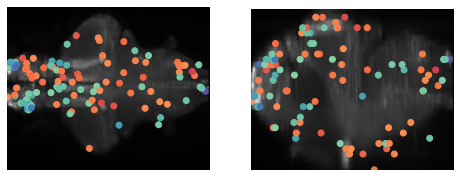

0.15458358207349154


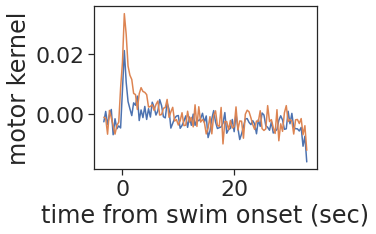

49


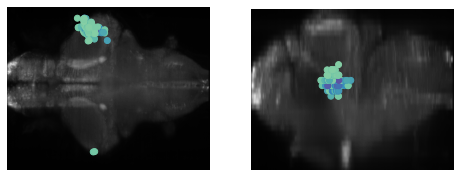

0.4867518083163156


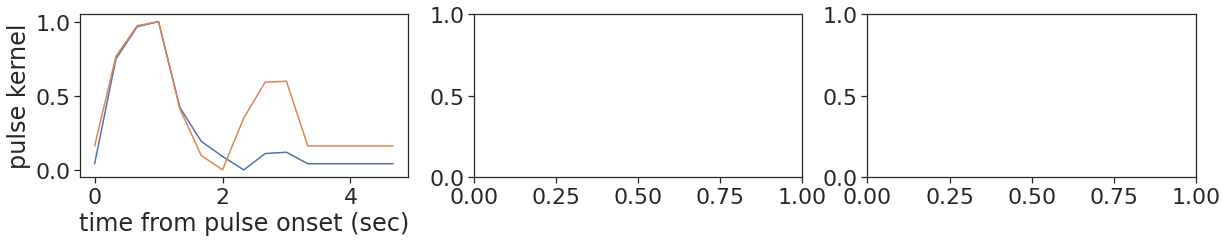

0.3054768337567788


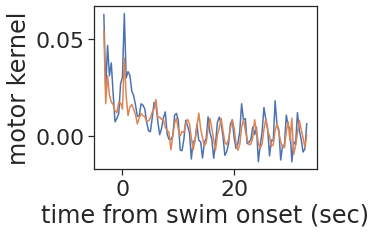

50


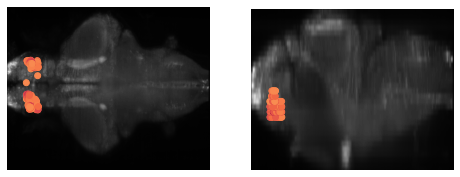

0.28196995065277697


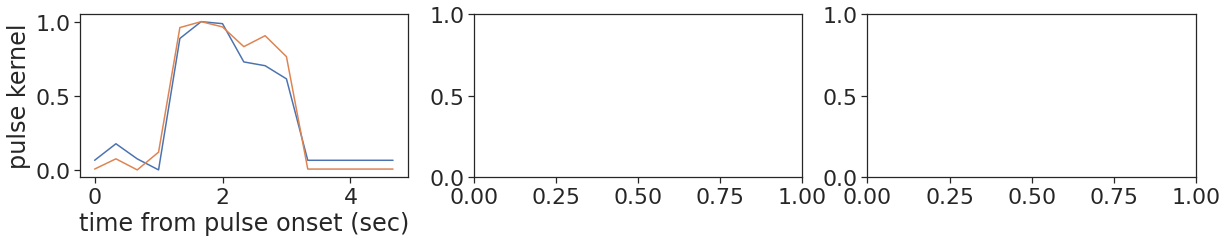

0.433091929697758


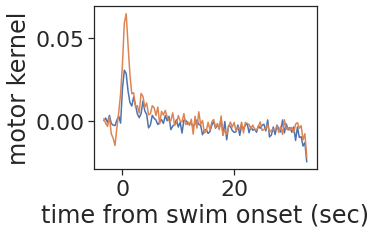

51


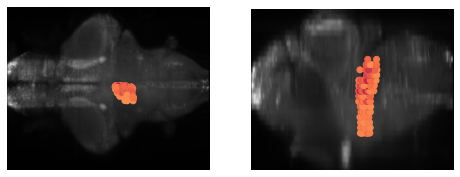

0.258965664827148


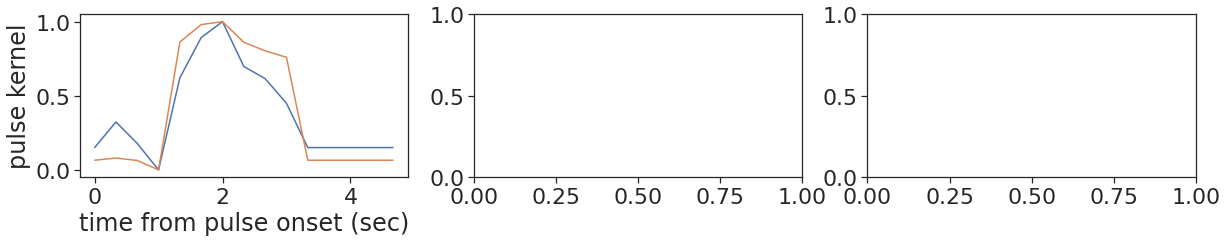

0.7048845042873445


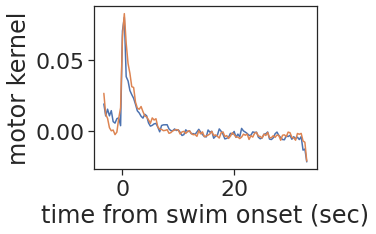

52


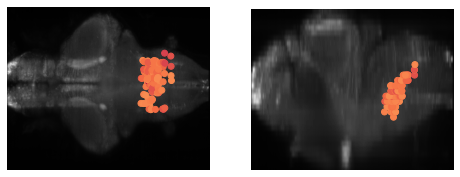

0.8341220099074613


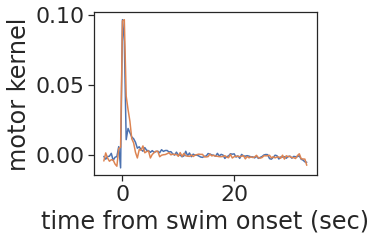

53


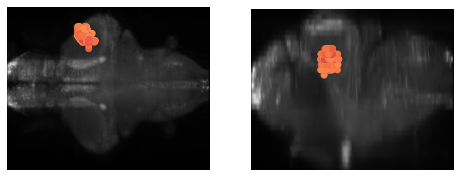

0.10361721354559761


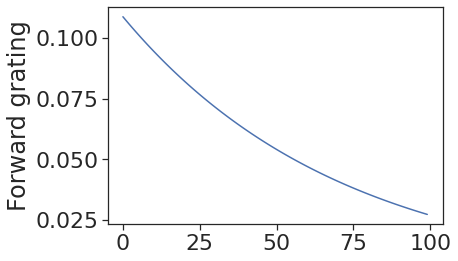

0.16931778313532753


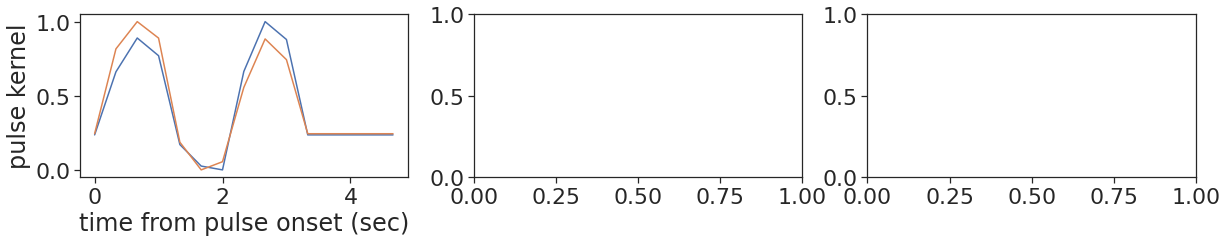

54


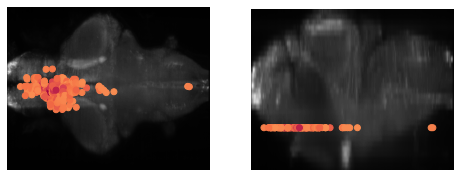

0.10720151392526078


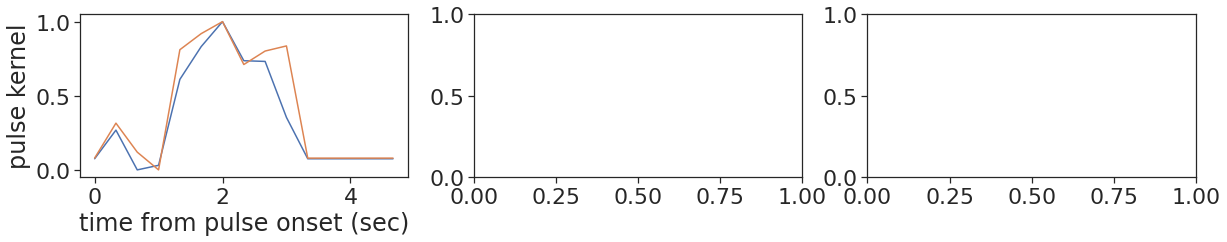

0.537764744073485


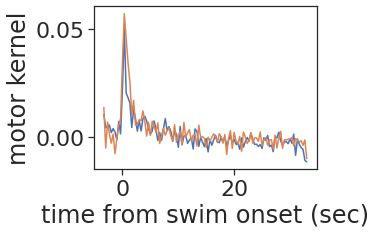

55


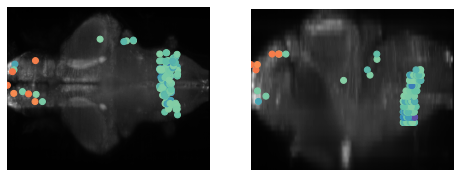

0.843677347984245


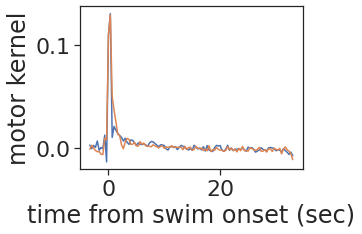

56


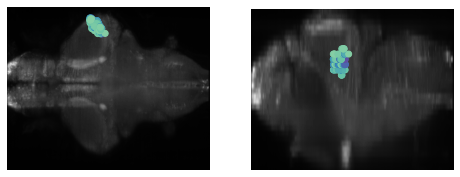

0.6120961786912694


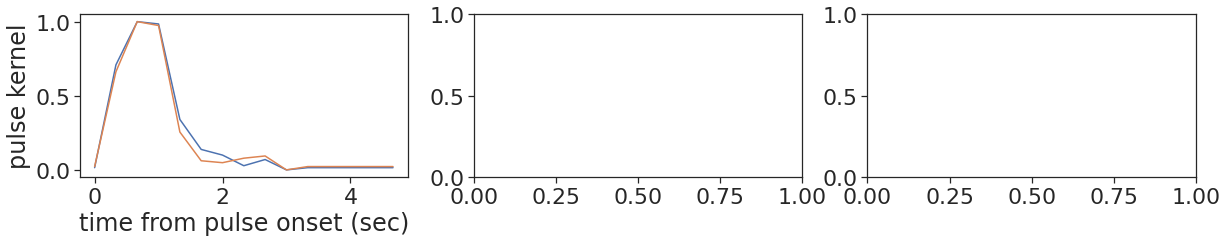

0.2431014467526289


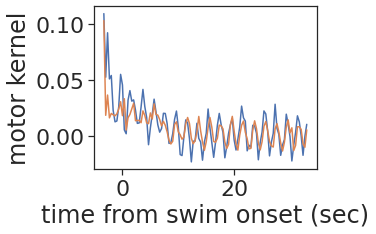

57


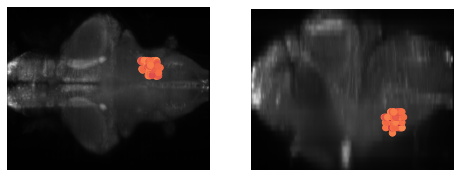

0.7157821012729448


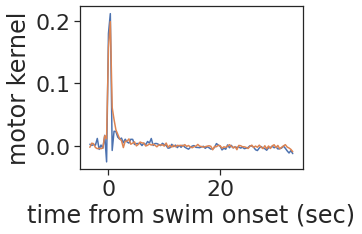

58


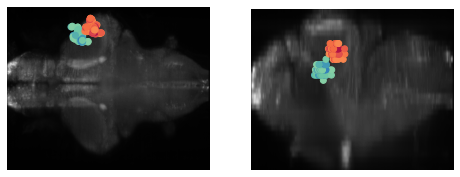

0.10102288738022058


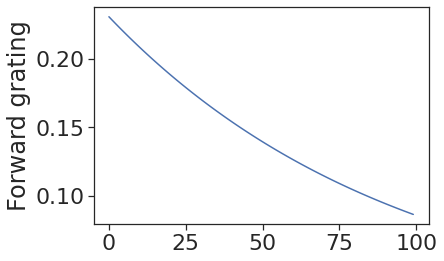

0.6879637793429327


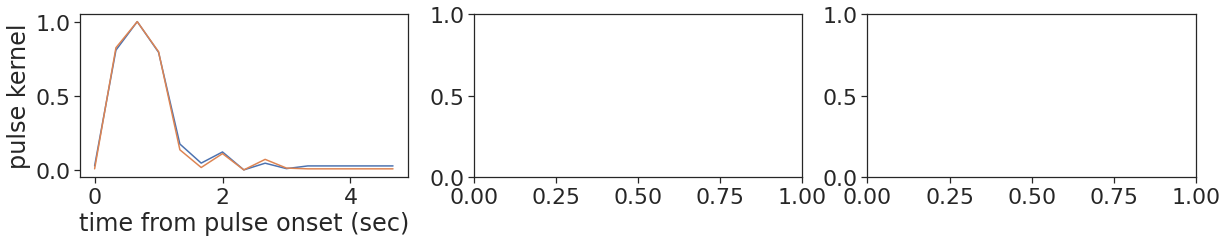

59


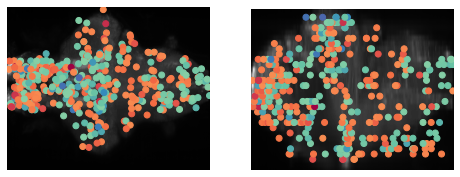

0.13649870366465156


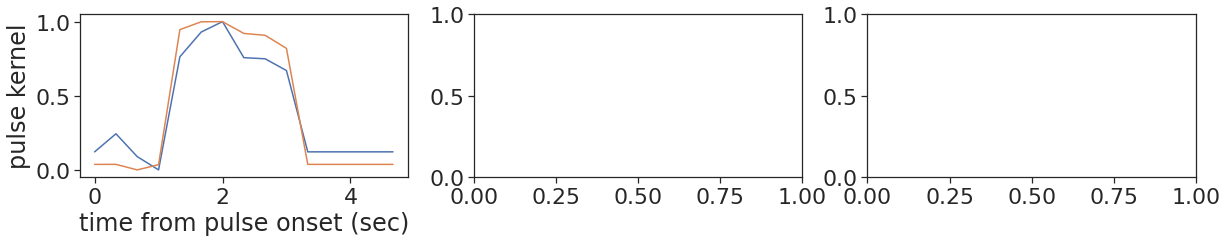

0.6674925703085285


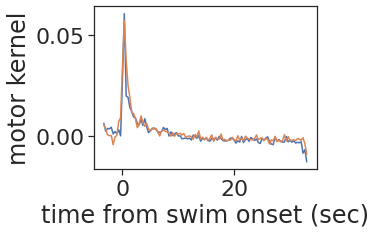

60


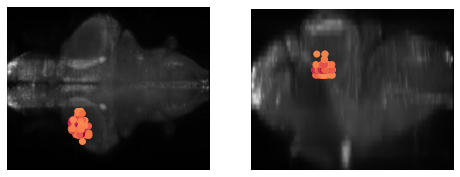

0.17608681792948422


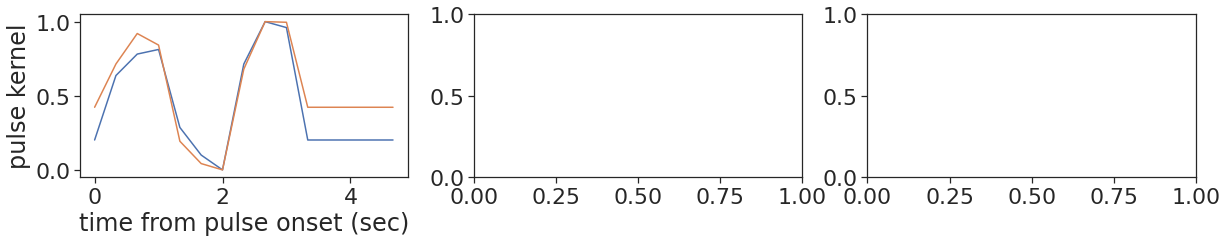

0.388073939040501


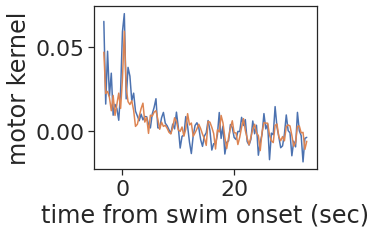

61


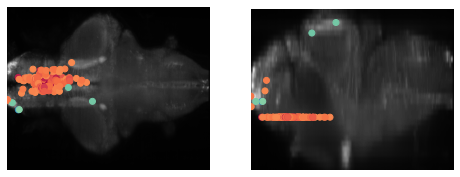

0.4500205150359393


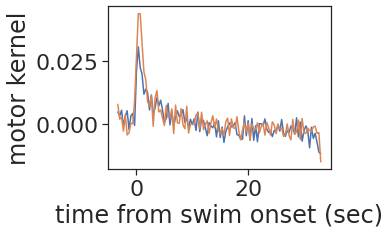

62


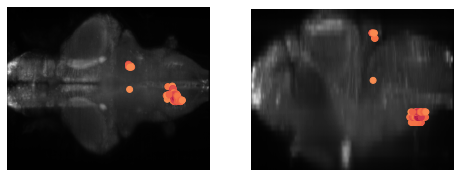

0.24697531842487086


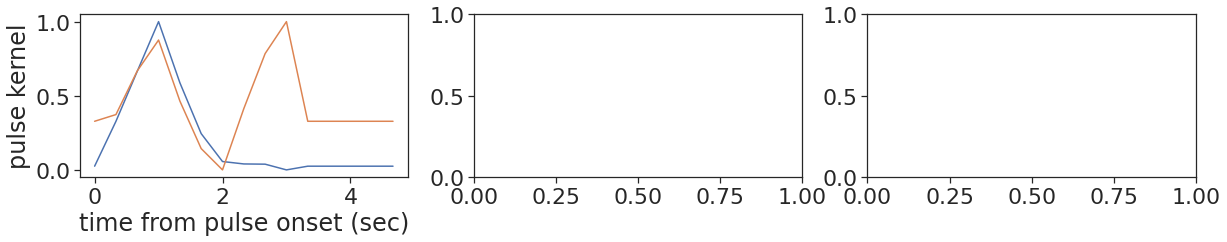

0.7635911000302416


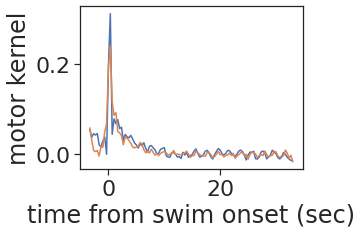

63


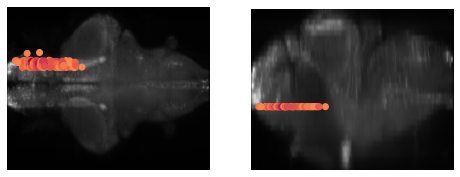

0.11307818151375515


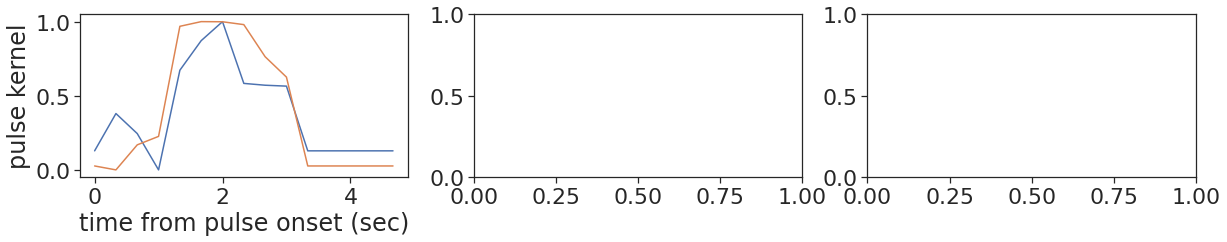

0.37740597118318964


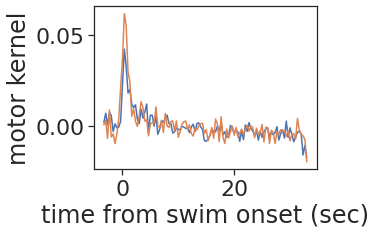

64


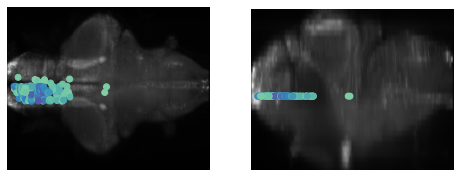

0.23966039827718089


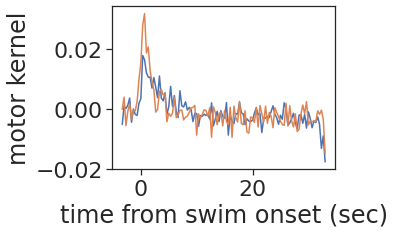

65


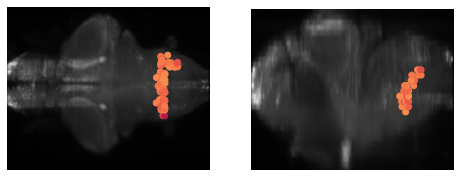

0.8301986295846129


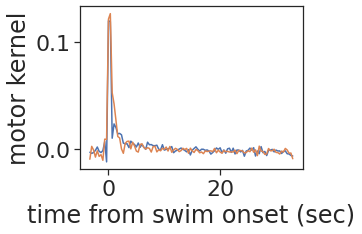

66


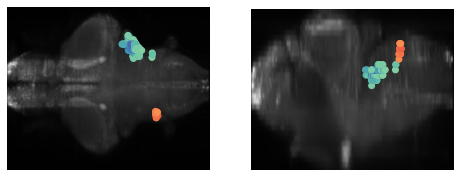

0.19430181577597472


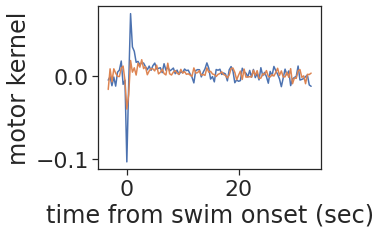

In [128]:
for cell_id in range(filtered_dFF.shape[0]):
    print(cell_id)
    w_resp_fg, w_visu, ev_fg, ev_visu, w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse, g_motor_cl, g_motor_ol, ev_motor = fit_results_[cell_id]
    
    if (ev_pulse<0.1) and (ev_fg<0.1) and (ev_motor<0.1):
        continue
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax=ax.flatten()
    
    
    ax[0].imshow(brain_map.max(axis=0), cmap=plt.cm.gray, aspect='auto')
    idx = (np.abs(loadings__[:,cell_id])>0)
    c_max=np.abs(loadings__[:,cell_id]).max()
    ax[0].scatter(x_[idx], y_[idx], c=loadings__[idx,cell_id], cmap=plt.cm.Spectral, vmax=c_max, vmin=-c_max)
    ax[0].set_axis_off()
    ax[0].set_xlim([0, brain_map.shape[2]])
    ax[0].set_ylim([0, brain_map.shape[1]])
    
    ax[1].imshow(brain_map.max(axis=1), cmap=plt.cm.gray, aspect='auto')
    idx = (np.abs(loadings__[:,cell_id])>0)
    c_max=np.abs(loadings__[:,cell_id]).max()
    ax[1].scatter(x_[idx], z_[idx], c=loadings__[idx,cell_id], cmap=plt.cm.Spectral, vmax=c_max, vmin=-c_max)
    ax[1].set_axis_off()
    ax[1].set_xlim([0, brain_map.shape[2]])
    ax[1].set_ylim([0, brain_map.shape[0]])
    plt.show()

    
    if ev_fg>0.1:
        print(ev_fg)
        plt.plot(w_resp_fg)
        plt.ylabel('Forward grating')
        plt.show()
    
    if ev_pulse>0.1:
        print(ev_pulse)
        fig, ax = plt.subplots(1, 3, figsize=(20, 3))
        ax = ax.flatten()
        ax[0].plot(np.arange(len(w_cl_pulse))/3, w_cl_pulse)
        ax[0].plot(np.arange(len(w_ol_pulse))/3,w_ol_pulse)
        ax[0].set_ylabel('pulse kernel')
        ax[0].set_xlabel('time from pulse onset (sec)')

#         ax[1].hist(g_t_matrix[cl_type].flatten())
#         ax[1].hist(g_t_matrix[ol_type].flatten())
#         ax[1].set_ylabel('distribution')
#         ax[1].set_xlabel('pulse amplitude')

#         ax[2].plot(np.mean(g_t_matrix[cl_type], axis=0))
#         ax[2].plot(np.mean(g_t_matrix[ol_type], axis=0))
#         ax[2].set_ylabel('pulse amplitude')
#         ax[2].set_xlabel('pulse index')
        plt.show()  
    
    t_pre = 10
    t_post=100
    if ev_motor>0.1:
        print(ev_motor)
        plt.figure(figsize=(4, 3))
        plt.plot(np.arange(-t_pre, t_post)/3, g_motor_cl)
        plt.plot(np.arange(-t_pre, t_post)/3, g_motor_ol)
        plt.ylabel('motor kernel')
        plt.xlabel('time from swim onset (sec)')
        plt.show()        

### Pulse components

In [11]:
ev_pulse_comp = []
ev_pulse_w = []
dff_pulse_comp = []
for cell_id in range(filtered_dFF.shape[0]):
    w_resp_fg, w_visu, ev_fg, ev_visu, w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse, g_motor_cl, g_motor_ol, ev_motor = fit_results_[cell_id]
    if (ev_pulse<0.1) and (ev_fg<0.1) and (ev_motor<0.1):
        continue
    if ev_pulse>0.1:
        ev_pulse_comp.append(cell_id)
        ev_pulse_w.append([w_cl_pulse, w_ol_pulse])
        dff_pulse_comp.append(comp_dFF(cell_id)) 

In [12]:
dff_pulse_comp = np.array(dff_pulse_comp)

In [13]:
epoch_frame = np.median(wrap_data(fileContent_[5], indx, frame_len), axis=0).astype('int')
swim_frame = np.mean(wrap_data(l_power_+r_power_, indx, frame_len), axis=0)
pulse_frame = np.median(wrap_data(fileContent_[8], indx, frame_len), axis=0).astype('int')
visu_frame = np.mean(wrap_data(fileContent_[3], indx, frame_len), axis=0)
visu_frame_ = visu_frame.copy()
visu_frame_[visu_frame_<0]=0

trial_ = epoch_frame%5 == 0
trial_start = np.where((~trial_[:-1]) & (trial_[1:]))[0]
trial_end = np.r_[trial_start, len(trial_)]
trial_start = np.r_[0, trial_start+1]
trial_len = dff_pulse_comp.shape[-1]
num_trial = min((trial_start<trial_len).sum(), (trial_end<trial_len).sum())
trial_end = trial_end[:num_trial]
trial_start = trial_start[:num_trial]

trial_type_ = []
pulse_ = []
swim_ = []
trial_valid = []
dff_pulse_ = []
num_pulses = np.zeros(num_trial)

for n in range(len(trial_start)):
    epoch_ = epoch_frame[trial_start[n]:trial_end[n]]
    _ = pulse_frame[trial_start[n]:trial_end[n]][epoch_%5==3]
    if _.sum()==0:
        trial_valid.append(False)
    else:
        trial_valid.append(True)
    pulse_trial_ = pulse_frame[trial_start[n]:trial_end[n]][epoch_%5>=3]
    pulse_input = np.zeros(pulse_trial_.shape)
    if (pulse_trial_>0).sum()>0:
        pulse_input[np.where(pulse_trial_[1:] & ~pulse_trial_[:-1])[0]+1]=1
        num_pulses[n] = pulse_input.sum()
    pulse_.append(pulse_input)
    swim_.append(swim_frame[trial_start[n]:trial_end[n]][epoch_%5>=3])
    trial_type_.append(epoch_[20]//5)
    dff_pulse_.append(dff_pulse_comp[:, trial_start[n]:trial_end[n]][:, epoch_%5>=3])

In [14]:
swim_median = np.percentile(np.hstack(swim_), 95)
swim_on = []
for n, _ in enumerate(swim_):
    if (_>0.5).sum()>0:
        swim_on.append(np.where(_>0.5)[0][0])
    else:
        swim_on.append(np.nan)
swim_on = np.array(swim_on)
trial_type_ = np.array(trial_type_)

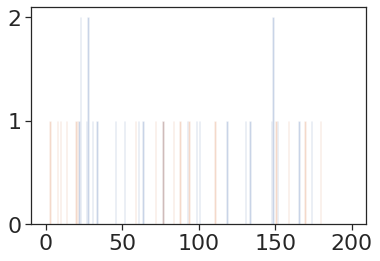

In [15]:
plt.hist(swim_on[trial_type_==0], bins=np.arange(0, 200, 1), alpha=0.3)
plt.hist(swim_on[trial_type_==1], bins=np.arange(0, 200, 1), alpha=0.3)
plt.show()

In [16]:
num_pulse = np.median(num_pulses).astype('int')
num_swim_frame = np.median([len(_) for _ in swim_]).astype('int')-3
num_comp = dff_pulse_comp.shape[0]

In [17]:
pulse_amp = []
for n in range(num_trial):
    n_pulse = pulse_[n]
    pulse_amp_ = np.zeros((num_comp, num_pulse))
    if len(n_pulse) == 0:
        pulse_amp.append(pulse_amp_)
        continue
    for ncomp in range(num_comp):
        dff_ = dff_pulse_[n][ncomp]
        w_resp_fg, w_visu, ev_fg, ev_visu, w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse, g_motor_cl, g_motor_ol, ev_motor = fit_results_[ncomp]
        g_t = np.ones(30)*0.1
        if trial_type_[n]==0:
            w_pulse_ = w_cl_pulse
        else:
            w_pulse_ = w_ol_pulse        
        _ = minimize(mse_pulse_g_t_resp_s, g_t, args=(dff_, n_pulse, w_pulse_))
        pulse_amp_[ncomp] = _['x']
    pulse_amp.append(pulse_amp_)

In [21]:
pulse_amp = np.array(pulse_amp)

In [22]:
swim_amp = np.zeros((num_trial, num_swim_frame))
swim_thres = 0.4
for n in range(num_trial):
    if trial_valid[n]:
        swim_amp[n] = np.clip(swim_[n][:num_swim_frame]-swim_thres, 0, np.inf)

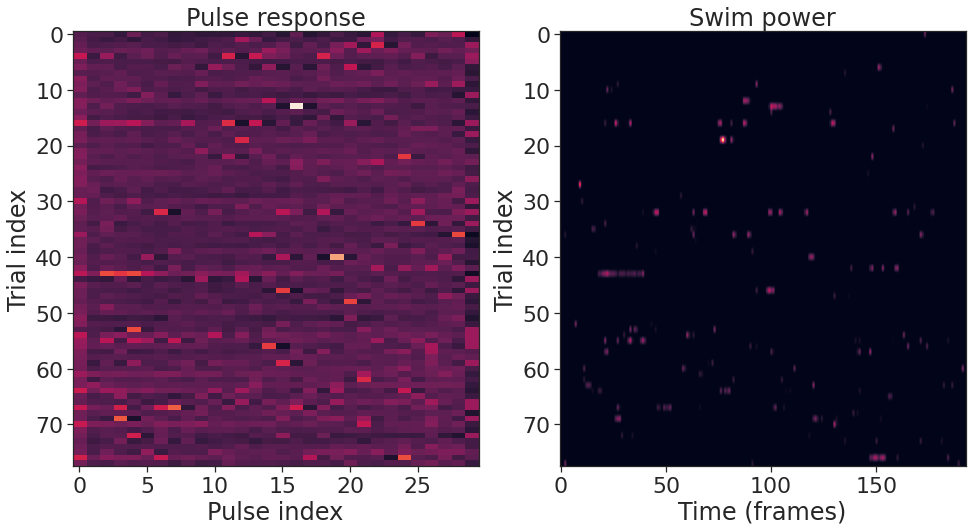

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(pulse_amp[trial_valid,0,:], aspect='auto')
ax[0].set_xlabel('Pulse index')
ax[0].set_ylabel('Trial index')
ax[0].set_title('Pulse response')
ax[1].imshow(np.sqrt(swim_amp[trial_valid]), aspect='auto')
ax[1].set_xlabel('Time (frames)')
ax[1].set_ylabel('Trial index')
ax[1].set_title('Swim power')
plt.show()

In [24]:
dFF_list = []
for cell_id in range(filtered_dFF.shape[0]):
    dFF_list.append(comp_dFF(cell_id))

In [25]:
dFF_list = np.array(dFF_list)

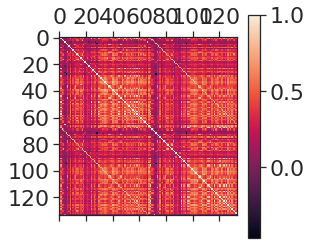

In [39]:
corr_, p_val = spearmanr(dFF_list[:, :-1], dFF_list[:, 1:], axis=1)
plt.matshow(corr_)
plt.colorbar()
plt.show()

In [44]:
from scipy.linalg import lstsq
AT, res, rank, s = lstsq(dFF_list[:, :-1].T, dFF_list[:, 1:].T)

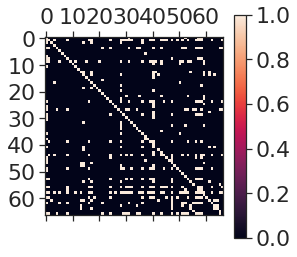

In [109]:
plt.matshow(np.abs(AT).T>0.1)
plt.colorbar()
plt.show()

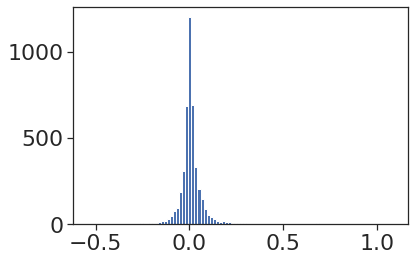

In [53]:
plt.hist(AT.flatten(), bins=100)
plt.show()

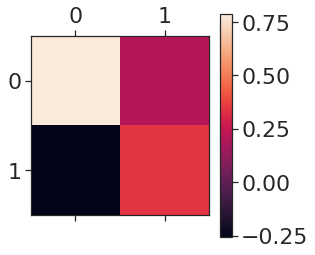

In [63]:
plt.matshow(AT[:2, :2])
plt.colorbar()

### Find the active vs passive brain-state period

In [110]:
CL_trial_time = np.zeros(trial_len)
OL_trial_time = np.zeros(trial_len)

for n in range(len(trial_start)):
    epoch_ = epoch_frame[trial_start[n]:trial_end[n]]
    _ = pulse_frame[trial_start[n]:trial_end[n]][epoch_%5==3]
    if _.sum()>0:
        pulse_start = np.where(epoch_%5==3)[0][0]
        pulse_end = np.where(epoch_%5==3)[0][-1]
        pulse_len = pulse_end - pulse_start
        if epoch_[0]==0:
            CL_trial_time[(trial_start[n]+pulse_start-10):trial_end[n]]=True
        elif epoch_[0]==5:
            OL_trial_time[(trial_start[n]+pulse_start-10):(trial_start[n]+pulse_start+pulse_len//2)]=True

In [111]:
CL_trial_idx = np.where(CL_trial_time)[0]
CAT, res, rank, s = lstsq(dFF_list[:, CL_trial_idx-1].T, dFF_list[:, CL_trial_idx].T)

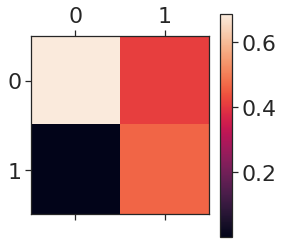

In [112]:
plt.matshow(CAT[:2, :2])
plt.colorbar()

In [113]:
OL_trial_idx = np.where(OL_trial_time)[0]
OAT, res, rank, s = lstsq(dFF_list[:, OL_trial_idx-1].T, dFF_list[:, OL_trial_idx].T)

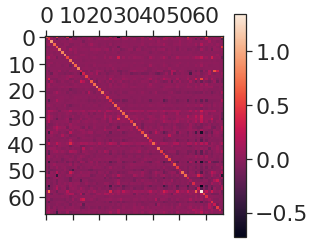

In [114]:
plt.matshow(CAT)
plt.colorbar()

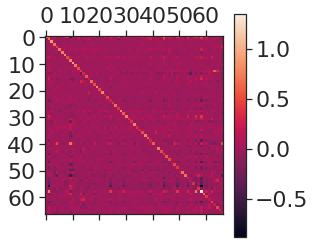

In [115]:
plt.matshow(OAT)
plt.colorbar()

In [116]:
def tot_var(x, axis=1):
    return ((x - x.mean(axis=axis, keepdims=True))**2).sum(axis=axis)

In [117]:
1-((OAT.T@dFF_list[:, OL_trial_idx-1] - dFF_list[:, OL_trial_idx])**2).sum(axis=1)/tot_var(dFF_list[:, OL_trial_idx], axis=1)

array([0.58993973, 0.52996594, 0.87277721, 0.56875594, 0.23628646,
       0.77345926, 0.65402061, 0.68093468, 0.39661975, 0.57589021,
       0.9224592 , 0.57404259, 0.5512654 , 0.60285599, 0.57508453,
       0.40597505, 0.33748678, 0.63625686, 0.44989456, 0.84366345,
       0.28425174, 0.68029465, 0.11942992, 0.32985828, 0.52124111,
       0.26368059, 0.47890115, 0.2827771 , 0.75002061, 0.53298463,
       0.56875022, 0.52193601, 0.49113393, 0.78108872, 0.60261233,
       0.41097828, 0.42690746, 0.79240702, 0.58864629, 0.4466956 ,
       0.68006746, 0.22605645, 0.77716597, 0.5312809 , 0.42498418,
       0.52392723, 0.57503068, 0.46930769, 0.48056737, 0.54004781,
       0.61532952, 0.79627042, 0.53005838, 0.50066882, 0.57001228,
       0.50802863, 0.52218207, 0.54171409, 0.4652744 , 0.68090673,
       0.44868225, 0.6201964 , 0.54865491, 0.62164477, 0.59875336,
       0.34297433, 0.29907495])

In [118]:
1-((CAT.T@dFF_list[:, CL_trial_idx-1] - dFF_list[:, CL_trial_idx])**2).sum(axis=1)/tot_var(dFF_list[:, CL_trial_idx], axis=1)

array([0.65767139, 0.52538998, 0.86046374, 0.59827816, 0.23904459,
       0.78271108, 0.70210329, 0.7006564 , 0.54654194, 0.57642741,
       0.57375465, 0.5327381 , 0.69197021, 0.57698369, 0.56589819,
       0.36139801, 0.31098373, 0.6815148 , 0.54009452, 0.77931667,
       0.348359  , 0.6770051 , 0.07225572, 0.34504851, 0.52260094,
       0.2939941 , 0.51968583, 0.32215452, 0.74633177, 0.56289457,
       0.55285887, 0.48398983, 0.53492705, 0.72194705, 0.61876189,
       0.47318806, 0.50284603, 0.81621752, 0.57713051, 0.45679981,
       0.67881705, 0.36776001, 0.75404797, 0.52592705, 0.44544882,
       0.56009776, 0.61292198, 0.49645826, 0.51291464, 0.56854133,
       0.4312222 , 0.72526502, 0.57643925, 0.48223454, 0.52743098,
       0.49780315, 0.54137641, 0.53742747, 0.47286258, 0.65560813,
       0.45860714, 0.56123322, 0.6385799 , 0.61753243, 0.61994873,
       0.37815498, 0.30060349])

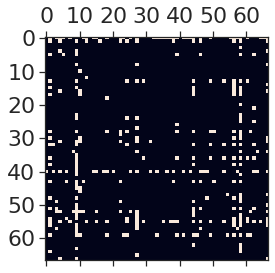

In [119]:
plt.matshow(np.abs(CAT - OAT)>0.1)

In [120]:
import networkx as nx

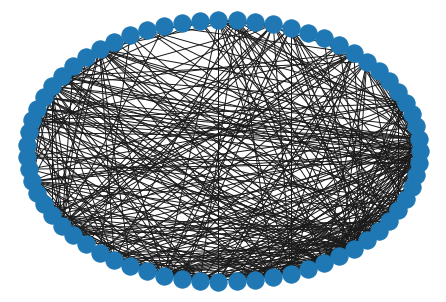

In [131]:
num_cells = filtered_dFF.shape[0]
motor_comp = np.zeros(num_cells).astype('bool')
sensory_comp = np.zeros(num_cells).astype('bool')
for cell_id in range(num_cells):
    w_resp_fg, w_visu, ev_fg, ev_visu, w_cl_pulse, w_ol_pulse, g_t_matrix, ev_pulse, g_motor_cl, g_motor_ol, ev_motor = fit_results_[cell_id]       
    if ev_pulse>0.2:    
        sensory_comp[cell_id]=True
    if ev_motor>0.2:    
        motor_comp[cell_id]=True

In [167]:
df_ = pd.DataFrame(np.array([motor_comp, sensory_comp]).T, columns=["motor", "senosory"])
df_ = df_.sort_values(["motor", "senosory"], ascending = (False, False))
sort_ind = df_.index.values
cell_type = df_["motor"]*2 + df_["senosory"]

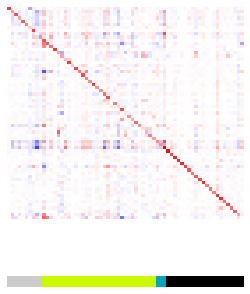

In [191]:
A = CAT.T.copy()
A = A[sort_ind][:, sort_ind]
# A[np.abs(A)<0.1]=0
# G = nx.from_numpy_matrix(A)
# nx.draw_circular(G)

fig, ax = plt.subplots(2,1, figsize=(4, 6))
pcm = ax[0].matshow(A, cmap=plt.cm.bwr, vmin=-1, vmax=1, aspect='auto')
ax[0].set_axis_off()
# fig.colorbar(pcm, ax=ax)
pcm = ax[1].matshow(np.array([cell_type]*3), cmap=plt.cm.nipy_spectral)
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

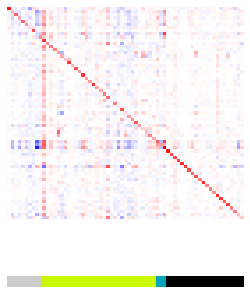

In [192]:
A = OAT.T.copy()
A = A[sort_ind][:, sort_ind]
# A[np.abs(A)<0.1]=0
# G = nx.from_numpy_matrix(A)
# nx.draw_circular(G)

fig, ax = plt.subplots(2,1, figsize=(4, 6))
pcm = ax[0].matshow(A, cmap=plt.cm.bwr, vmin=-1, vmax=1, aspect='auto')
ax[0].set_axis_off()
# fig.colorbar(pcm, ax=ax)
pcm = ax[1].matshow(np.array([cell_type]*3), cmap=plt.cm.nipy_spectral)
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

In [195]:
(~motor_comp & sensory_comp).sum()

3

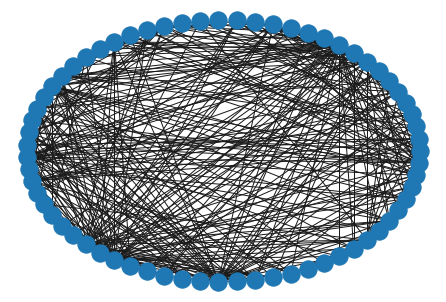

<Figure size 288x288 with 0 Axes>

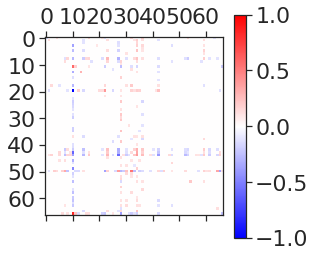

In [164]:
A = (CAT-OAT).T.copy()
A = A[sort_ind][:, sort_ind]
A[np.abs(A)<0.1]=0
G = nx.from_numpy_matrix(A)
nx.draw_circular(G)

plt.figure(figsize=(4, 4))
plt.matshow(A, cmap=plt.cm.bwr, vmin=-1, vmax=1)
plt.colorbar()
plt.show()